In [22]:
import pydicom
import string
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [34]:
'''
This function is an rle to mask converter.
You supply the rle string for one mask, along with it's height and width
from the solutions for stage1 and it will return the mask.
'''

def rleToMask(rle, height, width):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [3]:
def show_dcm_info(dataset):
#     print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [4]:
allImageDICOMsPaths = []

for line in tuple(open('./input/names.txt', 'r')):
    dicomPath = './input/dicom-images-train/' + line.strip('\n')
    allImageDICOMsPaths.append(dicomPath)

In [5]:
print('Total Paths specified: ', len(allImageDICOMsPaths))

Total Paths specified:  10675


In [6]:
## Read masks from csv
encodedMasksCsv = pd.read_csv('./input/train-rle.csv', names= ['ImageId', 'EncodedPixels'], index_col='ImageId')

# encodedMasksCsv.columns

encodedMasksCsv[:5]

,EncodedPixels
ImageId,
ImageId,EncodedPixels
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...


In [7]:
allDicomFiles = []

failed = 0
success = 0
for dPath in allImageDICOMsPaths:
    try:
        dataset = pydicom.dcmread(dPath)
        allDicomFiles.append({
            'fileId': dPath.split('/')[-1][:-4],
            'data': dataset
        })
        
        success = success + 1
    except Exception as e:
        failed = failed + 1

    clear_output(wait=True)
    print('success: ' + str(success) + ', failed: ' + str(failed) + ', Total: ' + str(success+failed))

success: 595, failed: 10080, Total: 10675


FileId: 1.2.276.0.7230010.3.1.4.8323329.2850.1517875175.70142
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 6454a216-348a-4740-ad81-88bc29a6193d, 
Patient id..........: 6454a216-348a-4740-ad81-88bc29a6193d
Patient's Age.......: 44
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 155128 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


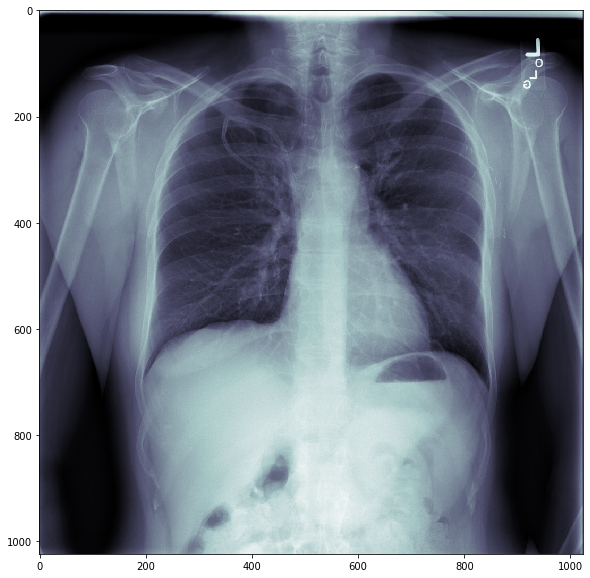

In [12]:
print('FileId: ' + allDicomFiles[0]['fileId'])
show_dcm_info(allDicomFiles[0]['data'])
plot_pixel_array(allDicomFiles[0]['data'])

In [37]:
im_height = 1024
im_width = 1024
im_chan = 1

dataSetCount = len(allDicomFiles)

# Get train images and masks
X_train = np.zeros((dataSetCount, im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((dataSetCount, im_height, im_width, 1), dtype=np.bool)

print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

maskFoundCount = 0

for i in tqdm(range(dataSetCount)):
    fileId = allDicomFiles[i]['fileId']
    dataset = allDicomFiles[i]['data']
    X_train[i] = np.expand_dims(dataset.pixel_array, axis=2)
    try:
        rle = encodedMasksCsv.loc[fileId, 'EncodedPixels']
        
        if '-1' in rle: # if rle (encoded mask) not available
            Y_train[i] = np.zeros((im_height, im_width, 1))
        else:
            if type(rle) == str: # if single rle (encoded mask)
                mask = rleToMask(rle, im_height, im_width)
                Y_train[i] = np.expand_dims(mask, axis=2)
            else: # if multiple rle (encoded mask)
                Y_train[i] = np.zeros((1024, 1024, 1))
                for x in rle:
                    Y_train[i] =  Y_train[i] + np.expand_dims(rleToMask(x, im_height, im_width), axis=2)
            maskFoundCount = maskFoundCount + 1
    except KeyError:
        print(f"Key {fileId} without mask, assuming healthy patient.")
        Y_train[i] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Total masks found: ', maskFoundCount)

X_train shape: (595, 1024, 1024, 1)
Y_train shape: (595, 1024, 1024, 1)



Total masks found:  147


In [38]:
# fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(5*10,10))
# for q in range(5):
    